<a href="https://colab.research.google.com/github/serg-kas/MNIST-for-YOLOv5/blob/main/MNIST_Data_preparation_for_OD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST

**Data preparation for YOLOv5**


In [ ]:
# Датасет
from tensorflow.keras.datasets import mnist 

# Работа с изображениями
import cv2 as cv
from PIL import Image
%matplotlib inline

#Базовые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Путь к папке с данным
PATH = '/content/drive/MyDrive/my_data/A-data/'

!ls {PATH}

11490434/11490434 [==============================] - 1s 0us/step
(70000, 28, 28)
(70000,)


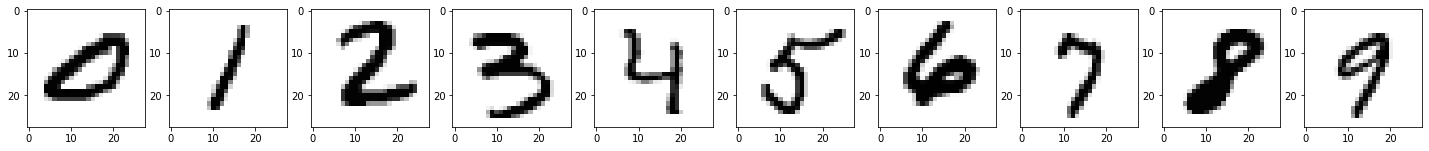

In [ ]:
# Загружаем MINST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Обединяем массивы 
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# Инвертируем изображения
x = np.invert(x)

# Смотрим форму данных
print(x.shape)
print(y.shape)

# Выводим на экран пример картинок
fig, axs = plt.subplots(1, 10, figsize=(25,3))  # будет 10 графиков по числу классов от 0 до 9

for i in range(10):
  label_indexes = np.where(y == i)[0]
  index = random.choice(label_indexes)  # случайный индекс из списка
  img = x[index]                        # изображение по индексу
  axs[i].imshow(Image.fromarray(img), cmap='gray') 

plt.show()


In [ ]:
# Создаем датасет из картинок 416 х 416 со случайным количеством рядов и случайным количеством символов в них
N = 5000           # сколько будет картинок в датасете
max_rows = 10      # сколько рядов цифр максимально
max_columns = 15   # сколько цифр в ряду (столбцов) максимально

#
img_list = []      # список создаваемых изображений
labels_list = []   # список меток классов по каждому изображению (список списков)
for i in range(N):
  #
  N_rows = random.randint(3, max_rows)
  N_columns = random.randint(3, max_columns)
  print("N_rows={}, N_columns={}".format(N_rows, N_columns))
  #
  img = np.ones((416,416), dtype=np.uint8) * 255  # пустое белое изображение
  #
  curr_img_labels = []  # метки классов
  #
  start_Y = 28 + random.randint(0, 56)
  step_Y = 28 + random.randint(28, 56)
  for r in range(N_rows):
    Y = start_Y + r * step_Y + random.randint(-10,10)
    #
    start_X = 28 + random.randint(0, 56)
    step_X = 28 + random.randint(0, 28)
    for c in range(N_columns):
      X = start_X + c * step_X + random.randint(0,10)
      #  
      random_idx = random.randint(0, x.shape[0] - 1)
      random_img = x[random_idx]
    
      # Ищем BBox'ы сначала на случайной (малой) картинке
      thresh = cv.threshold(random_img.copy(), 100, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
      x1, y1, w, h = cv.boundingRect(thresh)
      
      # Перейдем к координатам на основной картинке
      x1 = x1 + X
      y1 = y1 + Y
      x2 = x1 + w
      y2 = y1 + h
      start = (x1, y1)
      end = (x2, y2)
      colour = (0, 0, 0)
      thickness = 1
      # print("x1={}, y1={}, x2={}, y2={}".format(x1, y1, x2, y2))
      
      #
      if (Y+28 < 400) and (X+28 < 400) and (w < 27) and (h < 27):
        img[Y:Y+28, X:X+28] = random_img
        # img = cv.rectangle(img, start, end, colour, thickness)
        curr_img_labels.append([y[random_idx], 
                                round((x1 + x2) / 2 / 416, 6), 
                                round((y1 + y2) / 2 / 416, 6), 
                                round(w / 416, 6), 
                                round(h / 416, 6)
                                ])
  #  
  img_list.append(img)
  labels_list.append(curr_img_labels)
  print("Метки классов текущей картинки:", curr_img_labels)


images_np = np.array(img_list)
print(images_np.shape)

In [ ]:
# Переделываем картинки в BGR
color_list = []
for i in range(images_np.shape[0]):
  color_list.append(cv.cvtColor(images_np[i],cv.COLOR_GRAY2BGR))

images_np_color = np.array(color_list)
del color_list
print(images_np_color.shape)

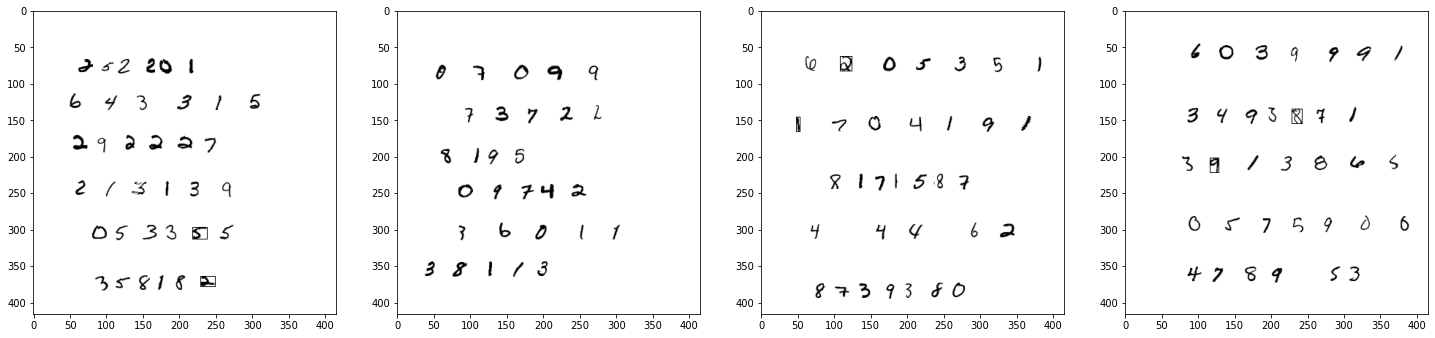

In [ ]:
#Выводим на экран пример картинок
fig, axs = plt.subplots(1, 4, figsize=(25,10)) 

for i in range(4):
  img = images_np_color[i] 
  axs[i].imshow(Image.fromarray(img), cmap='gray') 

plt.show()

In [ ]:
# Подготовим структуру датасета   
data_path = 'dataset' 
if not (data_path in os.listdir('.')):
        os.mkdir(data_path)
        print("Создали папку датасета: {}".format(data_path))
        os.mkdir(os.path.join(data_path, 'images'))
        os.mkdir(os.path.join(data_path, 'labels'))
        os.mkdir(os.path.join(data_path, 'images', 'train'))
        os.mkdir(os.path.join(data_path, 'images', 'valid'))
        os.mkdir(os.path.join(data_path, 'labels', 'train'))
        os.mkdir(os.path.join(data_path, 'labels', 'valid'))

In [ ]:
# Сохраним полученный датасет
train_part = 0.8
N_train = int(N * train_part)
print(N_train)

for i in range(N):
  if i <= N_train:
    out_file_name = os.path.join(data_path, 'images', 'train', str(i) + '.png')
    txt_file_name = os.path.join(data_path, 'labels', 'train', str(i) + '.txt')
  else:
    out_file_name = os.path.join(data_path, 'images', 'valid', str(i) + '.png')
    txt_file_name = os.path.join(data_path, 'labels', 'valid', str(i) + '.txt')
  print(out_file_name, txt_file_name)
  #
  img = images_np_color[i] 
  Image.fromarray(img[:, :, ::-1]).save(out_file_name, 'PNG')
  # 
  cur_labels = labels_list[i]
  with open(txt_file_name, 'w') as f:
    for line in cur_labels:
        for item in line:
          f.write(str(item)+' ')
        f.write("\n")


In [ ]:
!zip -r dataset_mnist.zip dataset

In [ ]:
!ls {PATH}

In [ ]:
!cp dataset_mnist.zip {PATH}
!ls {PATH}